In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal,stats
import pandas as pd
from typing import Dict
from collections import defaultdict
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.trials import select_trials
from ephysvibe.spike_sorting import config

In [2]:
py_filepath = "/home/INT/losada.c/Documents/data/test/lip/lip/2022-11-22_10-59-03_Riesling_lip_e1_r1.npy"
#2022-12-14_10-50-49_Riesling_lip_e1_r1

### Load file

In [3]:
py_f = np.load(py_filepath,allow_pickle=True).item(0)
sp_py = py_f['sp_data']
bhv = py_f['bhv']
print('sp_py keys:')
print(sp_py.keys())
print('bhv_py trial keys:')
print(bhv[0].keys())

sp_py keys:
dict_keys(['sp_samples', 'blocks', 'code_numbers', 'code_samples', 'eyes_values', 'lfp_values', 'samples', 'clusters_id', 'clusters_ch', 'clustersgroup', 'clusterdepth'])
bhv_py trial keys:
dict_keys(['trial', 'AbsoluteTrialStartTime', 'Btn1', 'Btn10', 'Btn2', 'Btn3', 'Btn4', 'Btn5', 'Btn6', 'Btn7', 'Btn8', 'Btn9', 'Eye', 'Eye2', 'EyeExtra', 'Gen1', 'Gen10', 'Gen11', 'Gen12', 'Gen13', 'Gen14', 'Gen15', 'Gen16', 'Gen2', 'Gen3', 'Gen4', 'Gen5', 'Gen6', 'Gen7', 'Gen8', 'Gen9', 'Joystick', 'Joystick2', 'KeyInput', 'Mouse', 'PhotoDiode', 'SampleInterval', 'Touch', 'CodeNumbers', 'CodeTimes', 'Block', 'BlockCount', 'Condition', 'CycleRate', 'Angle', 'BackgroundColor', 'Info', 'Position1', 'Position2', 'Position3', 'Position4', 'Position5', 'Position6', 'Scale', 'Status', 'Time', 'Zorder', 'ReactionTime', 'EndTimes', 'StartTimes', 'Attribute11', 'Attribute12', 'Attribute13', 'Attribute21', 'Attribute22', 'Attribute23', 'Attribute24', 'Attribute25', 'Attribute26', 'Code', 'FrameByF

### Select relevant trials

In [4]:
# Selec trials in a block
n_block = 2
trial_idx = select_trials.select_trials_block(sp_py,n_block)
# Selec correct trials
trial_idx = select_trials.select_correct_trials(bhv,trial_idx)
print('Number of clusters: %d'%len(sp_py['sp_samples'][0]))


Number of trials in block 2: 104
Number of correct trials in block 2: 80
Number of clusters: 16


In [5]:
len(sp_py['sp_samples'][0])

16

### Select trials by target code

In [6]:
# Define target codes 
target_codes= {
    # code: [ML axis], [plot axis]
    '127': [[10,0],[1,2]],
    '126': [[7,7],[0,2]],
    '125': [[0,10],[0,1]],
    '124': [[-7,7],[0,0]],
    '123': [[-10,0],[1,0]],
    '122': [[-7,-7],[2,0]],
    '121': [[0,-10],[2,1]],
    '120': [[7,-7],[2,2]],
}

In [7]:
# create dict with the trials that have each code
trials_idx = {}
for i_key,key in enumerate(target_codes.keys()):
    trials = []
    code_idx=[]
    for i_trial,code in zip(trial_idx, sp_py['code_numbers'][trial_idx]):
        idx=np.where(int(key) == code)[0]
        if len(idx)!=0:
            code_idx.append(idx[0])
            trials.append(i_trial)
    trials_idx[key]={'code_idx':code_idx,'trials_idx':trials}

## Plot rasters for each neuron for each target

#### define variables

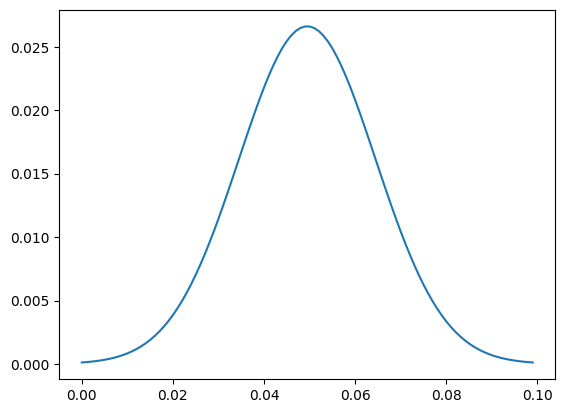

In [8]:
target_on = 37
fs = config.FS
downsample=config.DOWNSAMPLE
# kernel parameters
fs_ds = fs/downsample
w = 0.015 # seconds = 15 ms
w_size = 0.1 # seconds = 100ms
# define kernel for the convolution
kernel = signal.gaussian(M=w_size*fs_ds,std=w*fs_ds)
kernel=kernel/sum(kernel) # area of the kernel must be one
plt.plot(np.arange(len(kernel))/fs_ds,kernel)

#### Plot all trials with the same code for all neurons 

##### Split in stimulus presentation delay and saccade
Compute:
* visual pref / visual unpref -> target_on(37) - target_off(38)
* delay pref / delay unpref -> target_off(38) - fix_spot_off(36)
* saccade pref / saccade unpref -> fix_spot_off(10) - correct_response(40)

In [24]:
events = {
    'start_trial':9,
    'target_on': 37,
    'target_off': 38,
    'fix_spot_off': 36,
    'correct_response': 40,
    
    'end_trial':18
}

In [25]:
def align_neuron_spikes(trials_idx, sp_py, neuron, event_timestamps):
    # create list of neurons containing the spikes timestamps aligned with the event
    neuron_trials = []
    for i, i_t in enumerate(trials_idx):
        neuron_trials.append(sp_py["sp_samples"][i_t][neuron] - event_timestamps[i])
    return np.array(neuron_trials, dtype="object")

In [37]:
def trial_average_fr(neuron_trials):
    # Compute the Average firing rate
    sorted_sp_neuron = np.sort(np.concatenate(neuron_trials))
    sum_sp = np.zeros(int(sorted_sp_neuron[-1] - sorted_sp_neuron[0] + 1))
    sorted_sp_shift = np.array(sorted_sp_neuron - sorted_sp_neuron[0], dtype=int)
    for i in sorted_sp_shift:
        sum_sp[i] += 1
    trial_average_sp = sum_sp / len(neuron_trials)
    return trial_average_sp, sorted_sp_neuron

In [38]:
def compute_fr(neuron_trials,kernel,fs,downsample):
    trials_conv = []
    for i_trial in range(len(neuron_trials)):
        if len(neuron_trials[i_trial]) != 0:
            arr_timestamps = np.zeros(neuron_trials[i_trial][-1]+1) # array with n timestamps
            for sp in neuron_trials[i_trial]:
                arr_timestamps[sp] += 1
            # Downsample to 1ms
            arr_timestamps =np.sum(np.concatenate((arr_timestamps,np.zeros(downsample-len(arr_timestamps)%downsample))).reshape(-1,downsample),axis=1)

            conv = np.convolve(arr_timestamps,kernel,mode='same')*fs   
        else:
            conv=[0]
        trials_conv.append(conv)
    return trials_conv

In [80]:
def fr_in_window(x,start,end):
    fr = np.zeros(len(x))
    for i,i_x in enumerate(x):
        fr[i] = np.nan_to_num(np.mean(i_x[start[i]:end[i]]), nan=0)
    return fr


In [ ]:
def compute_mean_fr(conv,event_timestamps,align_event):
    for i,i_conv in enumerate(conv):
        np.array(len(conv[i])) - event_timestamps[i,align_event] # define timestamp vector corresponding with the shift
        # ver como hacer el mean ya que cada trial empieza en un momento dif (no est'an alineados)
        conv[i]
    

In [81]:
# plots x lim
x_lim_max = 2
x_lim_min = -0.7
# select only individual neurons
neurons = np.where(sp_py['clustersgroup']=='good')[0]
mean_fr:Dict[str,list] = defaultdict(list)
for i,neuron in enumerate(neurons):
    #fig,_ = plt.subplots(figsize=(8, 8),sharex=True,sharey=True)
    for code in target_codes.keys():
        target_trials_idx = trials_idx[code]["trials_idx"] # select trials with the same stimulus
        ev_timestamps = firing_rate.select_events_timestamps(sp_py,target_trials_idx, events) # select events timestamps for all trials
        neuron_trials = align_neuron_spikes(target_trials_idx, sp_py, neuron, ev_timestamps[:,0])# set the 0 at the event start trial
        shift_ev_timestamps = np.floor(((ev_timestamps.T-ev_timestamps.T[0]).T)/downsample)
        conv= compute_fr(neuron_trials,kernel,fs/downsample,downsample)
        visual_mean_fr = fr_in_window(x=conv,start=shift_ev_timestamps[:,1],end=shift_ev_timestamps[:,2])
        delay_mean_fr = fr_in_window(x=conv,start=shift_ev_timestamps[:,2],end=shift_ev_timestamps[:,3])
        saccade_mean_fr = fr_in_window(x=conv,start=shift_ev_timestamps[:,3],end=shift_ev_timestamps[:,4])
        # add values to dict
        length = len(target_trials_idx)
        mean_fr['neuron'] += [i+1]*length*3
        mean_fr['code'] += [code] *length*3
        mean_fr['event'] += ['visual']*length
        mean_fr['event'] += ['delay']*length
        mean_fr['event'] += ['saccade']*length
        mean_fr['trial'] += target_trials_idx * 3 # 3 times trials idx (for each window)
        mean_fr['fr'] += np.concatenate((visual_mean_fr,delay_mean_fr,saccade_mean_fr)).tolist()
                
        #conv_max=np.max(conv[:int(round((x_lim_max*fs-sorted_sp_neuron[0])/downsample,0))])
        # plot
        all_trials_fr = compute_mean_fr(conv=conv,event_timestamps=shift_ev_timestamps)
        # sample_first_sp = sorted_sp_neuron[0]/downsample
        # ds_neuron_trials = neuron_trials/downsample
        # axis= target_codes[code][1]
        # ax = plt.subplot2grid((3, 3), (axis[0], axis[1]))
        #fig=firing_rate.plot_raster_fr(sample_first_sp,conv,fs_ds,ds_neuron_trials,code,ax,fig,i,x_lim_max,x_lim_min,conv_max,events=mean_idx_events)

    #fig.legend(['Target ON'], fontsize=9)
    #plt.show()
mean_fr=pd.DataFrame(mean_fr)

In [64]:
"""124/120
125/121
126/122
127/123"""

'124/120\n125/121\n126/122\n127/123'

In [88]:
t_test:Dict[str,list] = defaultdict(list)
for i_n, neuron in enumerate(neurons):
    for event in ['visual','delay','saccade']:
        for i,code_i in enumerate([['124','120'],['125','121'],['126','122'],['127','123']]):
            a=mean_fr[(mean_fr['neuron']==i_n+1) & (mean_fr['event']==event)& (mean_fr['code']==code_i[0])]
            b=mean_fr[(mean_fr['neuron']==i_n+1) & (mean_fr['event']==event)& (mean_fr['code']==code_i[1])]
            p=stats.ttest_ind(a['fr'].values, b['fr'].values, axis=0)
            t_test['codes']+=[code_i]
            t_test['neuron']+=[i_n+1]
            t_test['event']+=[event]
            t_test['p']+=[p[1]]
t_test=pd.DataFrame(t_test)

In [89]:
t_test[t_test['neuron']==8]

,codes,neuron,event,p
84,"[124, 120]",8,visual,0.162944
85,"[125, 121]",8,visual,0.751729
86,"[126, 122]",8,visual,0.509670
87,"[127, 123]",8,visual,0.993884
88,"[124, 120]",8,delay,0.667147
89,"[125, 121]",8,delay,0.020182
90,"[126, 122]",8,delay,0.419946
91,"[127, 123]",8,delay,0.113214
92,"[124, 120]",8,saccade,0.000684
93,"[125, 121]",8,saccade,0.045755
